In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.set_printoptions(precision=6)

In [4]:
# Set the hyperparameters for data creation
NUM_CLASSES = 3
NUM_FEATURES = 2
RANDOM_SEED = 47

# 1. Create multi-class data
X, y = make_blobs(n_samples=2000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.8, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)


In [5]:
X.shape, y.shape

((2000, 2), (2000,))

In [6]:
y

array([1, 0, 0, ..., 0, 2, 0])

In [7]:
# X

In [8]:

def get_scaled_feature(X: np.array):
    m = np.mean(X, axis=0)
    s = np.std(X, axis=0)
    
    return (X - m) / s

In [9]:
X = get_scaled_feature(X)

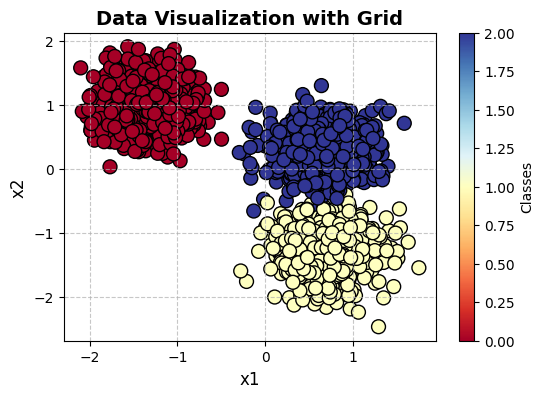

In [10]:
# let's plot the data
plt.figure(figsize=(6, 4))

# scatter plot with labels and grid
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k', s=100)

# add title, labels, and grid
plt.title('Data Visualization with Grid', fontsize=14, fontweight='bold')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# display color bar to indicate classes
plt.colorbar(label='Classes')

# display the plot
plt.show()

In [11]:
# Reshape y to be a 2D array for OneHotEncoder
y = y.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the labels
y_one_hot = encoder.fit_transform(y)

In [12]:
y_one_hot.shape

(2000, 3)

In [13]:
# y_one_hot

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y_one_hot,
        test_size=0.2,
        random_state=47
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1600, 2), (1600, 3), (400, 2), (400, 3))

In [15]:
X_train, X_test, y_train, y_test = X_train.T, X_test.T, y_train.T, y_test.T

In [16]:
# dims are (n, m) for X_train and (C, m) for y_train
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2, 1600), (3, 1600), (2, 400), (3, 400))

In [17]:
# X_train

In [18]:
# let's define a function to initialize the parameters

def parameters_initialization(n=X_train.shape[0], C=y_train.shape[0]):
    W = np.random.randn(n, C) * 0.01
    b = np.random.randn(C, 1) * 0.01
    
    return {"W": W, "b": b}

In [19]:
params = parameters_initialization()
params['W'], params['b']

(array([[ 0.018737,  0.009988,  0.00046 ],
        [-0.002   ,  0.006553,  0.002677]]),
 array([[-0.026772],
        [-0.003491],
        [-0.005671]]))

In [20]:
# now, let's define the softmax fn

def softmax(Z):
    # Z has a shape of (C, m)
    # subtract the max value for numerical stability (softmax is invariant to constant shifts).
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    
    # exponentiate Z (shifted Z)
    exp_Z = np.exp(Z_shifted)
    
    # sum of exp(Z) across classes
    sum_exp_Z = np.sum(exp_Z, axis=0, keepdims=True)
    
    # compute the softmax (probabilities)
    P_hat = exp_Z / sum_exp_Z
    
    return P_hat

In [21]:
# let's define the forward fn

def forward(W, b, X):
    # let's calculate the logits (Z)
    Z = np.dot(W.T, X) + b
    
    # get the softmax
    P_hat = softmax(Z)
    
    return P_hat

In [22]:
def compute_cost(P_hat, y_train, m=X_train.shape[1]):
    # P_hat has shape (C, m), and y_train is one-hot encoded with shape (C, m)
    L_i = -np.sum(y_train * np.log(P_hat), axis=0)  # only log the correct class probabilities
    
    # cost (total loss)
    cost = (1./m) * np.sum(L_i)
    
    return cost

In [23]:
# now, let's compute the gradients

def compute_gradients(X_train, y_train, P_hat, m=X_train.shape[1]):
    # get the difference 
    # (P_hat - y_train)
    diff = (P_hat - y_train)
    
    # cost wrt W
    dW = (1./m) * np.dot(X_train, diff.T)
    
    # cost wrt b
    db = (1./m) * np.sum(diff, axis=1, keepdims=True)
    
    return {"dW": dW, "db": db}

In [24]:
# training loop

def training_loop(X_train, y_train, n_iterations, lr=0.001, print_cost=True):
    # let's initialize the parameters
    parameters = parameters_initialization()
    W, b = parameters['W'], parameters['b']
    
    costs = []
    
    for i in range(n_iterations):
        # forward pass
        P_hat = forward(W=W, b=b, X=X_train)
        
        # compute cost
        cost = compute_cost(P_hat=P_hat, y_train=y_train)
        
        # compute gradients
        gradients = compute_gradients(X_train=X_train, 
                                        y_train=y_train, 
                                        P_hat=P_hat)
        
        if print_cost and (i % 1000 == 0):
            print(f"Cost at {i}th iteration is: {cost}")
            print(f"W: {W} || b: {b}\n")
        
        # update the parameters
        W = W - (lr * gradients['dW'])
        b = b - (lr * gradients['db'])
        
        costs.append(cost)
    
    opt_params = {
        
        "W": W,
        "b": b
        
    }
    
    return costs, opt_params

In [25]:
n_iterations = 10000

costs, opt_parameters = training_loop(
            X_train=X_train,
            y_train=y_train,
            n_iterations=n_iterations,
            lr=0.01
)

Cost at 0th iteration is: 1.1016262817532796
W: [[-0.00217  -0.009735 -0.016331]
 [ 0.005774 -0.001703 -0.00775 ]] || b: [[-0.011786]
 [ 0.014722]
 [-0.011288]]

Cost at 1000th iteration is: 0.21153424227402412
W: [[-1.376132  0.376404  0.971492]
 [ 0.731524 -1.481838  0.746634]] || b: [[-0.179188]
 [-0.130559]
 [ 0.301395]]

Cost at 2000th iteration is: 0.13299771430675045
W: [[-1.790374  0.429816  1.332323]
 [ 0.90346  -1.997578  1.090439]] || b: [[-0.263792]
 [-0.218982]
 [ 0.474422]]

Cost at 3000th iteration is: 0.10227840502025184
W: [[-2.050223  0.470827  1.55116 ]
 [ 1.019182 -2.329619  1.306758]] || b: [[-0.308592]
 [-0.278772]
 [ 0.579012]]

Cost at 4000th iteration is: 0.0854638389077228
W: [[-2.242664  0.5067    1.707728]
 [ 1.110031 -2.578634  1.464923]] || b: [[-0.337817]
 [-0.326957]
 [ 0.656422]]

Cost at 5000th iteration is: 0.07467132751852884
W: [[-2.396839  0.53951   1.829093]
 [ 1.18624  -2.779762  1.589842]] || b: [[-0.359085]
 [-0.368646]
 [ 0.719379]]

Cost at 6

In [26]:

# Plot the cost over iterations
def plot_cost_over_iterations(n_iterations, costs):
    
    plt.figure(figsize=(6, 4))  # Set the figure size

    # Plot the costs over iterations
    plt.plot(range(n_iterations), costs, color='b', linewidth=2, label='Cost')

    # Customizing the plot
    plt.xlabel('Iterations', fontsize=10)
    plt.ylabel('Cost', fontsize=10)
    plt.title(f'Cost Function Over Iterations', fontsize=12)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add a legend
    plt.legend(loc='best', fontsize=10)

    # Display the plot
    plt.tight_layout()
    plt.show()

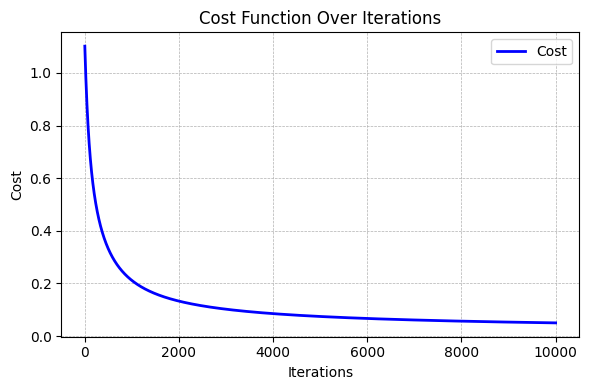

In [27]:
plot_cost_over_iterations(n_iterations=n_iterations, costs=costs)

In [28]:
opt_W = opt_parameters['W']
opt_b = opt_parameters['b']

In [29]:
opt_W

array([[-2.906549,  0.679677,  2.198636],
       [ 1.461069, -3.452545,  1.987796]])

In [30]:
opt_b

array([[-0.418032],
       [-0.530255],
       [ 0.939934]])

In [31]:
def compute_accuracy(P_hat, y_true):
    """
    Compute the accuracy of the model.
    
    Parameters:
    P_hat -- softmax predictions of shape (C, m)
    y_true -- true labels (one-hot encoded) of shape (C, m)
    
    Returns:
    accuracy -- scalar accuracy of the model
    """
    # Get the predicted class (index of the maximum probability for each example)
    predicted_classes = np.argmax(P_hat, axis=0)
    
    # Get the true class (index of the one-hot encoded true labels)
    true_classes = np.argmax(y_true, axis=0)
    
    # Compute accuracy by comparing predicted and true classes
    accuracy = np.mean(predicted_classes == true_classes)
    
    return accuracy


In [32]:
P_hat_train = forward(W=opt_W, b=opt_b, X=X_train)
P_hat_test = forward(W=opt_W, b=opt_b, X=X_test)

In [33]:
# Calculate training accuracy
train_accuracy = compute_accuracy(P_hat_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_accuracy = compute_accuracy(P_hat_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 99.38%
Test Accuracy: 99.25%


In [34]:

def plot_decision_boundary(X, y, W, b, resolution=0.01):
    """
    Plot the decision boundary of a trained logistic regression model.
    
    Parameters:
    X -- The input features (2D array, shape (n, m))
    y -- The true class labels (1D array or one-hot encoded, shape (C, m))
    W -- Trained weights (shape (n, C))
    b -- Trained bias (shape (C, 1))
    resolution -- The resolution of the grid for the decision boundary (default 0.01)
    """
    # Create a meshgrid that covers the range of X values
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                            np.arange(y_min, y_max, resolution))
    
    # Flatten the grid points and create a new input feature matrix for prediction
    grid_points = np.c_[xx.ravel(), yy.ravel()].T  # Shape (2, number of grid points)
    
    # Predict class probabilities for each grid point using the forward function
    Z = forward(W=W, b=b, X=grid_points)
    
    # Convert softmax probabilities to predicted class labels
    Z_pred = np.argmax(Z, axis=0)
    
    # Reshape the predictions back into the shape of the meshgrid
    Z_pred = Z_pred.reshape(xx.shape)
    
    # Plot the contour and the decision boundary
    plt.contourf(xx, yy, Z_pred, alpha=0.8, cmap=plt.cm.RdYlBu)
    
    # Plot the original training points
    if y.ndim == 2:  # If y is one-hot encoded, convert it to class labels
        y = np.argmax(y, axis=0)
    
    plt.scatter(X[0, :], X[1, :], c=y, edgecolor='k', s=100, cmap=plt.cm.RdYlBu)
    
    # Set plot limits and labels
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Decision Boundary')
    plt.show()


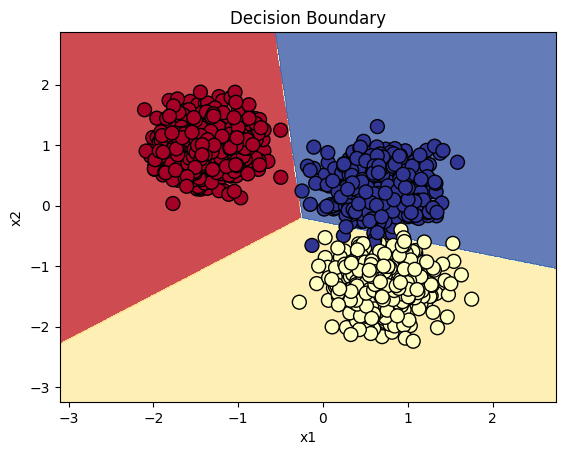

In [35]:
plot_decision_boundary(X_train, y_train, W=opt_W, b=opt_b)

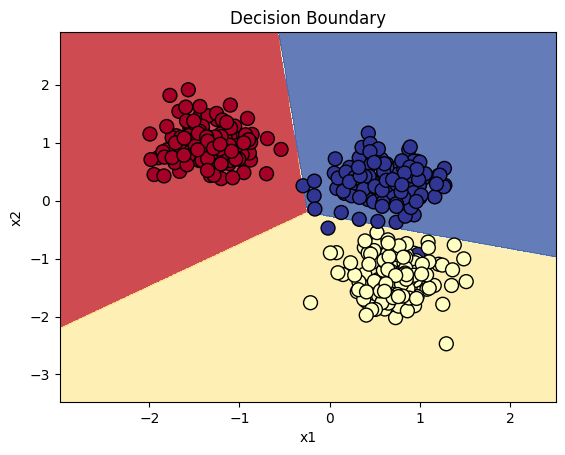

In [36]:
# test set
plot_decision_boundary(X_test, y_test, W=opt_W, b=opt_b)

In [40]:
A_inv = np.linalg.pinv(opt_W.T)
A_inv

array([[-0.202395,  0.018817,  0.181448],
       [ 0.056157, -0.18942 ,  0.132795]])

In [41]:
X_solve = np.dot(A_inv, opt_b)
X_solve

array([[0.245179],
       [0.201784]])